# Import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import datetime as dt
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from numpy import savetxt, loadtxt
from scipy.integrate import simps

time_stamps = [f'{int(i/2):02d}:{int((i%2)*30):02d}' for i in range(48)]
ticks = ('00:00','03:00','06:00','09:00', '12:00','15:00', '18:00','21:00', '23:30')

In [2]:
import os
import torch
from torch.nn import Parameter

import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import pyro.ops.stats as stats

smoke_test = ('CI' in os.environ)  # ignore; used to check code integrity in the Pyro repo
assert pyro.__version__.startswith('1.8.4')
pyro.set_rng_seed(1)

# Reading Data

In [3]:
import dask.dataframe as dd

def combine_csv_files(csv_files=['GP9_2023/GP9_202301.csv','GP9_2023/GP9_202302.csv','GP9_2023/GP9_202303.csv','GP9_2023/GP9_202304.csv']):   


    # create an empty list to hold the dataframes
    # columns to read from csv
    cols_to_read = ['Settlement Date', 'GSP Id', 'Settlement Period', 'Meter Volume']
    
    ddf_list = [dd.read_csv(file, header=0, usecols=cols_to_read, 
                            dtype={'Settlement Date': 'uint32', 'GSP Id': 'category', 'Settlement Period': 'int8', 'Meter Volume': 'float32'}) 
                for file in csv_files]
    # concatenate the dask dataframes
    combined_ddf = dd.concat(ddf_list, ignore_index=True)
    #print(combined_ddf.compute().iloc[1])
    # filter by GSP Id
    #combined_ddf = combined_ddf.map_partitions(lambda df: df[df['GSP Id'] == gsp_id].drop(columns='GSP Id'))
    # drop duplicate rows and sort the resulting dataframe by 'Settlement Date' and 'Settlement Period'
    combined_ddf = combined_ddf.drop_duplicates(split_every=4)
    combined_ddf = combined_ddf.sort_values(['Settlement Date', 'Settlement Period']).reset_index(drop=True)
    combined_ddf = combined_ddf.compute()
    return combined_ddf

combined = combine_csv_files()

# Sorting the input

In [4]:
sorted_gsp = combined.sort_values(['GSP Id', 'Settlement Date', 'Settlement Period']).reset_index(drop=True)
print('sorted_gsp: ', sorted_gsp)

unique_gsps = sorted_gsp['GSP Id'].unique()
print('unique_gsps: ', unique_gsps[1])


sorted_gsp:           Settlement Date  GSP Id  Settlement Period  Meter Volume
0               20200907  ACTL_C                  1         7.639
1               20200907  ACTL_C                  2         7.415
2               20200907  ACTL_C                  3         7.101
3               20200907  ACTL_C                  4         6.807
4               20200907  ACTL_C                  5         6.539
...                  ...     ...                ...           ...
9560929         20230418  SAFO_1                 44        11.830
9560930         20230418  SAFO_1                 45        10.925
9560931         20230418  SAFO_1                 46        10.080
9560932         20230418  SAFO_1                 47         9.340
9560933         20230418  SAFO_1                 48         8.755

[9560934 rows x 4 columns]
unique_gsps:  AMEM_1


In [5]:
# Reading GSPs with non zeros input
gsps_nonzero = loadtxt('nonzero_gsps.csv', dtype=str)
print(gsps_nonzero.shape)

(362,)


In [6]:
# Setting up GSP list to apply GPLVM on
gsp_list = ['CHSI_1', 'MILH_1', 'ALVE1']
gsp_list = gsps_nonzero


#for each in gsp_list:
    #index = np.where(gsps_nonzero == each)
    #print(index[0][0])

# Calculating integrated PSD for the GSPs selected and number of days

In [7]:
integrated_psd_list = []
start_date = '20221212'
end_date = '20221216'

for each in gsp_list:
    specific_gsp_data = sorted_gsp[sorted_gsp['GSP Id'] == each]

    specific_gsp_data_copy = specific_gsp_data.copy()
    specific_gsp_data_copy = specific_gsp_data_copy.set_index(['Settlement Date'])
    specific_gsp_data_copy

    #specific_gsp_data_copy
    specific_gsp_data_copy_filtr = specific_gsp_data_copy.loc[start_date : end_date]
    #print('specific_gsp_data_copy_filtr: ', specific_gsp_data_copy_filtr)

    # convert into x and y
    x = list(range(len(specific_gsp_data_copy_filtr.index)))
    y = specific_gsp_data_copy_filtr['Meter Volume']
    y = y / np.max(y) #(normalized energy usage)

    # apply fast fourier transform and take absolute values
    f=np.fft.fft(y)
    #print(f.shape)

    # get the list of frequencies
    num=np.size(x)
    #print(num)
    #print(list(range(num)))
    freq = np.fft.fftfreq(num, 1)

    # get the list of spectrums
    spectrum=f.real*f.real+f.imag*f.imag
    #print(np.max(spectrum))
    if np.max(spectrum) != 0.0:
        nspectrum=spectrum / np.max(spectrum)
    else:
        #print(spectrum)
        nspectrum = spectrum

    a = freq[0:7]
    b = freq[-6:]
    freq_range = np.concatenate((b, a))

    c = nspectrum[:7]
    d = nspectrum[-6:]
    psd = np.concatenate((d, c))

    integrated_psd = simps(psd, freq_range)

    integrated_psd_list.append(integrated_psd)

In [8]:
# Displaying PSD values of all the GSPs selected
#integrated_psd_list
df = pd.DataFrame(integrated_psd_list, columns=['int_psd'])
df.values

array([[0.00300749],
       [0.00300551],
       [0.00462346],
       [0.00292095],
       [0.00298592],
       [0.00292724],
       [0.00337513],
       [0.00294252],
       [0.00293674],
       [0.00382258],
       [0.00428033],
       [0.00248754],
       [0.00296375],
       [0.00302417],
       [0.00294813],
       [0.00287307],
       [0.00304953],
       [0.00297284],
       [0.00283817],
       [0.00296831],
       [0.00292037],
       [0.00282381],
       [0.00300657],
       [0.00422541],
       [0.00280759],
       [0.0029244 ],
       [0.00284859],
       [0.00299788],
       [0.00291568],
       [0.00483655],
       [0.00315951],
       [0.00295255],
       [0.00290039],
       [       nan],
       [0.00299787],
       [0.00366381],
       [0.00282707],
       [0.00294702],
       [0.00301307],
       [0.00301233],
       [0.00293602],
       [0.00300054],
       [0.00299382],
       [0.00304607],
       [0.01093264],
       [0.00303167],
       [0.00302303],
       [0.002

# Applying threshold on integrated PSD for categorizing each GSP on battery installability

In [9]:
# Applying threshold on integrated PSD for categorizing battery or no-battery installability

# for 5 week days - 0.0035, for 2 week days/weekend - 0.008
psd_threshold = 0.0034

df['psd_index'] = np.where(df['int_psd'] <= psd_threshold, 1, 2)

In [10]:
df = df.set_index('psd_index')

# Processing each GSP specific data for number of days chosen above

In [11]:
# most of the gsps are having maximum days as '1810' by observation in the present dataset 
no_of_days = int(len(specific_gsp_data_copy_filtr) / 48)

# initializing a 3D array with zeros having dimensions containing 'GSPs', 'No. of days', 'No. of hrs'
transformed_data = np.zeros((len(gsp_list), no_of_days, 48))
i = 0
j = 0;

for each_gsp in gsp_list:
    
    # filter each GSP(location) data from the combined sorted dataset 
    specific_gsp_data = sorted_gsp[sorted_gsp['GSP Id'] == each_gsp]
    #print('sorted_gsp: ', specific_gsp_data)

    specific_gsp_data_copy = specific_gsp_data.copy()
    specific_gsp_data_copy = specific_gsp_data_copy.set_index(['Settlement Date'])
    specific_gsp_data_copy

    #specific_gsp_data_copy
    location_data = specific_gsp_data_copy.loc[start_date : end_date]
    
    #compute unique dates for each GSP data
    unique_dates= location_data.index.unique()
    #print('len(unique_dates): ', len(unique_dates))
    
    #cutfirst = np.empty([1810, 48])
    #print('Empty cutfirst: ', cutfirst)
    
    # considering only the gsp data having no of days greater 
    # or equals to the previously stored number (max no. of days)
    if(len(unique_dates)>= no_of_days):
        
        # initialization
        total_hrs = no_of_days*48
        date_index = 0
        
        for date in unique_dates:
            #print('date: ', date)
            # considering only electricity consumption hourly data ('metered volume ') for each date
            cutfirst1 = location_data[location_data.index == date]['Meter Volume']
            
            if cutfirst1.size >= 48:
                cutfirst1 = cutfirst1[:48].values.reshape(1, 48)
                
            else:
                while cutfirst1.size < 48 :
                    cutfirst1 = pd.concat([cutfirst1, cutfirst1.tail(1)], axis=0)
                
                cutfirst1 = cutfirst1.values.reshape(1, 48)
            
            if date_index == 0:
                cutfirst = cutfirst1
            else:
                cutfirst = np.append(cutfirst, cutfirst1, axis=0)
                
            date_index += 1
        #print('cutfirst shape: ', cutfirst.shape)
        transformed_data[i] = cutfirst.reshape(1, no_of_days, 48)
        #print(len(cutfirst))
    else:
        j += 1
        print('Number of dates are lesser for GSP index: ', i, 'and the number is: ', len(unique_dates))
        # Deleteing gsps having lesser days(no. of days) than the maximum
        gsps_nonzero = np.delete(gsps_nonzero, np.where(gsps_nonzero == unique_gsps[i]))
    
    i += 1
    #break
    

#newly transformed data shape
print(transformed_data.shape)
print(j)


(362, 5, 48)
0


In [12]:
# Reshaping the transformed data in 2D structure
new = transformed_data.reshape(transformed_data.shape[0], (no_of_days*48))

new.shape

(362, 240)

# Normalized energy usage

In [13]:

# Normalize the energy usage for selected period

# Do not divide if a single row contains all zeros to avoid NaN values after normalization
out = np.zeros((new.shape))
new = np.divide(new, np.max(new, axis=1, keepdims=True), 
                    out=out, where=np.max(new, axis=1, keepdims=True)!=0)
new.shape



(362, 240)

# Preparing input as Pytorch tensor for GPLVM model

In [14]:
data = torch.tensor(new, dtype=torch.get_default_dtype())
# we need to transpose data to correct its shape
y = data.t()

print(y.shape)
#print(y)

torch.Size([240, 362])


In [15]:

#capture_time = torch.tensor(df.int_psd.values, dtype=torch.get_default_dtype())
capture_time = y.new_tensor(df.index.values)
#print(capture_time)
# we scale the time into the interval [0, 1]
time = capture_time.log2()
#print(time)

# we setup the mean of our prior over X
X_prior_mean = torch.zeros(y.size(1), 2)  # shape: 362 x 2 (when GSP count: 362)
X_prior_mean[:, 0] = time

print(X_prior_mean)

tensor([[0., 0.],
        [0., 0.],
        [1., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [1., 0.],
        [1., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [1., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [1., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [1., 0.],
        [0., 0.],
        [1., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [1., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0

# Setting up the kernel and model

In [16]:
kernel = gp.kernels.RBF(input_dim=2, lengthscale=torch.ones(2), variance=torch.tensor(0.5))

# we clone here so that we don't change our prior during the course of training
X = Parameter(X_prior_mean.clone())
#print(X)

# we will use SparseGPRegression model with num_inducing=32;
# initial values for Xu are sampled randomly from X_prior_mean
Xu = stats.resample(X_prior_mean.clone(), 2)
#print(y)
print(X.shape, y.shape, Xu.shape)

#likelihood = gp.likelihoods.MultiClass(num_classes=2)

gplvm = gp.models.SparseGPRegression(X, y, kernel, Xu, noise=torch.tensor(0.01), jitter=1e-5)

torch.Size([362, 2]) torch.Size([240, 362]) torch.Size([2, 2])


In [17]:
# we use `.to_event()` to tell Pyro that the prior distribution for X has no batch_shape
gplvm.X = pyro.nn.PyroSample(dist.Normal(X_prior_mean, 0.1).to_event())
gplvm.autoguide("X", dist.Normal)

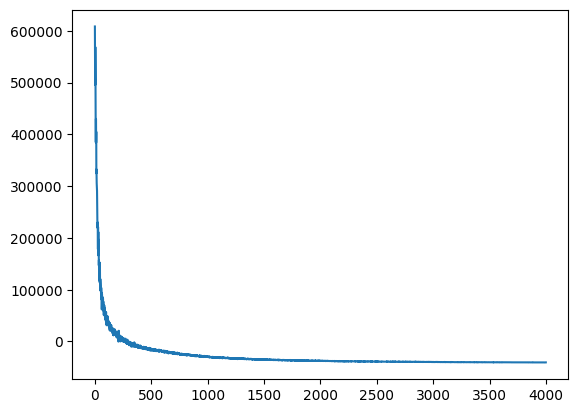

In [18]:
# note that training is expected to take a minute or so
losses = gp.util.train(gplvm, num_steps=4000)

# let's plot the loss curve after 4000 steps of training
plt.plot(losses)
plt.show()

In [19]:
'''
mean, var = gplvm(X)
print(mean, var)
y_hat = gplvm.likelihood(mean, var)

print(f"Accuracy: {(y_hat==y).sum()*100/(len(y)) :0.2f}%")

'''

'\nmean, var = gplvm(X)\nprint(mean, var)\ny_hat = gplvm.likelihood(mean, var)\n\nprint(f"Accuracy: {(y_hat==y).sum()*100/(len(y)) :0.2f}%")\n\n'

# Coordinates of all the points in latent space

In [20]:
gplvm.mode = "guide"
X_out = gplvm.X_loc.detach().numpy()  # draw a sample from the guide of the variable X
#print(X_out)

# Coordinates of all the points in latent space
for i, x in enumerate(X_out):
    print('Point: ', x, 'in GSP: ', gsp_list[i])
    

Point:  [-0.07339417  0.00365968] in GSP:  ACTL_C
Point:  [ 0.09839328 -0.00355712] in GSP:  AMEM_1
Point:  [ 6.3676333e-01 -9.9014193e-05] in GSP:  BARKC1
Point:  [-0.08324584 -0.00081953] in GSP:  BARKW3
Point:  [-0.01173573  0.00167481] in GSP:  BEDDT1
Point:  [-0.19256483 -0.00099728] in GSP:  BESW_1
Point:  [0.35671824 0.00239063] in GSP:  BICF_1
Point:  [ 0.10752197 -0.00263898] in GSP:  BIRK_1
Point:  [-0.09065416 -0.00202273] in GSP:  BISW_1
Point:  [0.38655254 0.00423921] in GSP:  BLYTB1
Point:  [ 8.7384933e-01 -4.4004453e-04] in GSP:  BLYTH132
Point:  [ 0.06253811 -0.00283248] in GSP:  BRAI_1
Point:  [-0.09182431 -0.00113535] in GSP:  BRED_1
Point:  [0.18333697 0.00078665] in GSP:  BRFO_1
Point:  [-0.06570659 -0.00501047] in GSP:  BRIM_1
Point:  [0.1101113  0.00329308] in GSP:  BURM_1
Point:  [ 0.02489812 -0.00016736] in GSP:  BUSH_1
Point:  [-0.16329205  0.0056813 ] in GSP:  BUST_1
Point:  [-0.14558297  0.00170628] in GSP:  CAPEA1
Point:  [ 1.5741958e-01 -8.0418497e-05] in G

# Visualization

labels:  Int64Index([1, 2], dtype='int64', name='psd_index')
(362, 2)
battery points count:  289
no battery points count:  73
The first two GSP points with coordinates:  [-0.07339417, 0.0036596833] , [0.098393284, -0.0035571225]


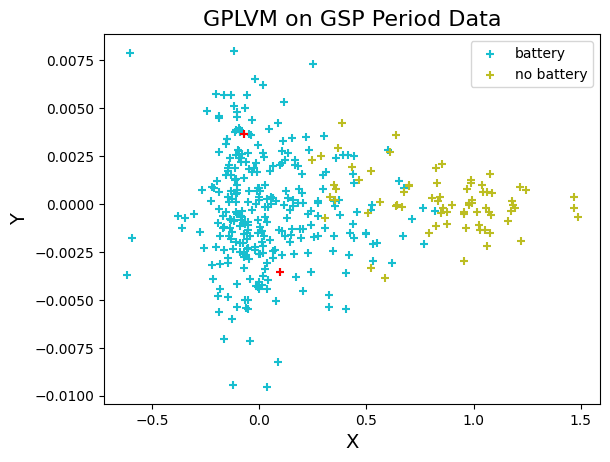

In [21]:
# Visulization part after applying GPLVM on input dataset
#plt.figure(figsize=(8, 6))
colors = plt.get_cmap("tab10").colors[::-1]
#labels = [1, 2]
labels = df.index.unique()
battery_types = ['battery', 'no battery']

print('labels: ', labels)
print(X_out.shape)
X_out = gplvm.X_loc.detach().numpy()
clustered_gsps = []

for i, label in enumerate(labels):

    X_i = X_out[df.index == label]
    print(battery_types[i], 'points count: ', len(X_i))
    plt.scatter(X_i[:, 0], X_i[:, 1], c=[colors[i]], marker='+', label=battery_types[i])
    clustered_gsps.append(gsps_nonzero[df.index == label])

# Highlighting specific points in the plot for battery and no-battery
plt.scatter(X_out[:2, 0], X_out[:2, 1], c=['red'], marker='+')
print('The first two GSP points with coordinates: ', [X_out[0][0], X_out[0][1]], ',', [X_out[1][0], X_out[1][1] ]) 

plt.legend()
plt.xlabel("X", fontsize=14)
plt.ylabel("Y", fontsize=14)
plt.title("GPLVM on GSP Period Data", fontsize=16)
plt.show()

# Visualization with contour plot

labels:  Int64Index([1, 2], dtype='int64', name='psd_index')
(362, 2)
battery points count:  289
no battery points count:  73


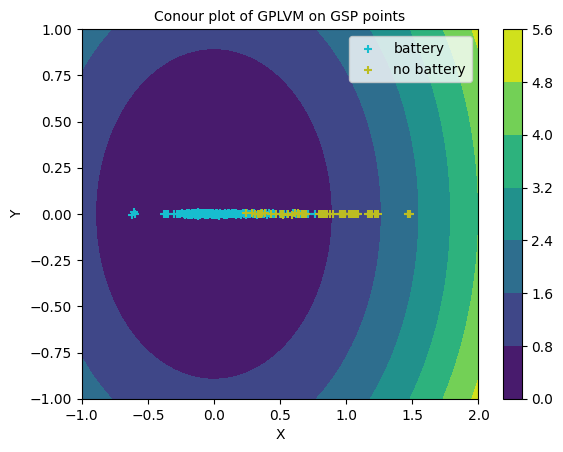

In [22]:
# Visulization part after applying GPLVM on input dataset
#plt.figure(figsize=(8, 6))
fig, ax = plt.subplots(1, 1)
colors = plt.get_cmap("tab10").colors[::-1]
#labels = [1, 2]
labels = df.index.unique()
battery_types = ['battery', 'no battery']

print('labels: ', labels)
print(X_out.shape)

feature_x = np.linspace(np.floor(np.min(X_out[:,0])), np.ceil(np.max(X_out[:,0])), 70)
feature_y = np.linspace(np.floor(np.min(X_out[:,1])), np.ceil(np.max(X_out[:,1])), 70)

X, Y = np.meshgrid(feature_x, feature_y)
Z = X**2 + Y**2

# plots filled contour plot
cp = ax.contourf(X, Y, Z)
plt.colorbar(cp)

for i, label in enumerate(labels):

    X_i = X_out[df.index == label]
    print(battery_types[i], 'points count: ', len(X_i))
    ax.scatter(X_i[:, 0], X_i[:, 1], c=[colors[i]], marker='+', label=battery_types[i])
    #print(X_i[:, 0], X_i[:, 1])

#plt.scatter(X_out[:, 0], X_out[:, 1], c= 'violet', marker='+', label='Data points')

plt.legend()
plt.xlabel("X", fontsize=10)
plt.ylabel("Y", fontsize=10)
plt.title("Conour plot of GPLVM on GSP points", fontsize=10)
plt.show()

# Visualize geospatial view of GSPs for battery & no-battery

2


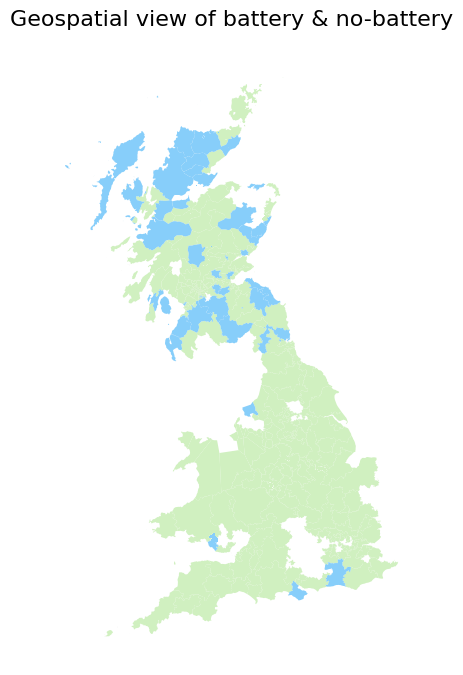

In [23]:
# To visualize the above cluster categories in geospatial map
import geopandas as gpd
from matplotlib.colors import ListedColormap

shapefile = gpd.read_file("../Data/gsp_regions_20220314/GSP_regions_20220314.shp")
print(len(clustered_gsps))

fig, ax = plt.subplots(figsize=(8, 8))
#mycolors = ['#FF6347', '#F62817', '#F9966B', '#E78A61', '#F67280', '#F67280']
mycolors = ['#d0f0c0', '#87cefa']

for each, color in zip(clustered_gsps, mycolors):
    
    filtered = shapefile[shapefile['GSPs'].isin(each)]
    merged = shapefile.merge(filtered)
    merged.plot(ax=ax, cmap=ListedColormap(color))


#ax.legend()
ax.set_xlabel("pseudotime", fontsize=14)
ax.set_ylabel("branching", fontsize=14)
ax.set_title("Geospatial view of battery & no-battery", fontsize=16)
plt.axis('off')
plt.show()

In [30]:
# Battery coordinate range for marginal points
battery_coord_range = {'left':[-1.5, -0.5], 'right':[0.5, 0.6], 'top':[0.005, 0.0075], 'bottom':[-0.01, -0.0075]}

# No battery coordinate range for marginal points
no_battery_coord_range = {'left':[0.4, 0.6], 'right':[1.4, 3.0], 'top':[0.0025, 0.0075], 'bottom':[-0.01, -0.0025]}

# Arrays of all battery and no-battery points in latent space

In [43]:
# Arrays of battery and no-battery points
X_battery_pts = X_out[df.index == 1]
X_no_battery_pts = X_out[df.index == 2]

# Consider two random point indices for the each category
battery_pt_indices = np.random.randint(0, len(X_battery_pts), size = 2)
no_battery_pt_indices = np.random.randint(0, len(X_no_battery_pts), size = 2)


In [44]:
#print(X_out[0])

# Any two latent points for battery zone
bt_pt1 = X_battery_pts[battery_pt_indices[0]]
bt_pt2 = X_battery_pts[battery_pt_indices[1]]

# Any two latent points for no-battery zone
no_bt_pt1 = X_no_battery_pts[no_battery_pt_indices[0]]
no_bt_pt2 = X_no_battery_pts[no_battery_pt_indices[1]]
#print(bt_pt1)

# Tensor mode of two latent points for each category zone
latent1 = torch.tensor([bt_pt1])
latent2 = torch.tensor([bt_pt2])
latent3 = torch.tensor([no_bt_pt1])
latent4 = torch.tensor([no_bt_pt2])

def get_mean(latent):
    m,C=gplvm(latent, full_cov=True)
    #print("m: ", m.detach().numpy(), "C: ", C.shape)
    print("latent variable", latent, "variance=", np.linalg.norm(C.detach().numpy()))
    return m.detach().numpy() 

time_span = 96
#
f1=get_mean(latent1)[:time_span]
f2=get_mean(latent2)[:time_span]
f3=get_mean(latent3)[:time_span]
f4=get_mean(latent4)[:time_span]
#
print(f1.shape[0])
l=f1.shape[0]
times=np.arange(int(l)) # half hourly interval
#
#print(times)

latent variable tensor([[ 0.0356, -0.0044]]) variance= 0.0069198655
latent variable tensor([[-0.1048, -0.0054]]) variance= 0.002700921
latent variable tensor([[ 1.2227, -0.0019]]) variance= 0.018548312
latent variable tensor([[1.2433e+00, 7.1377e-04]]) variance= 0.016053477
96


# Time series representation of random points in latent space for battery or no-battery

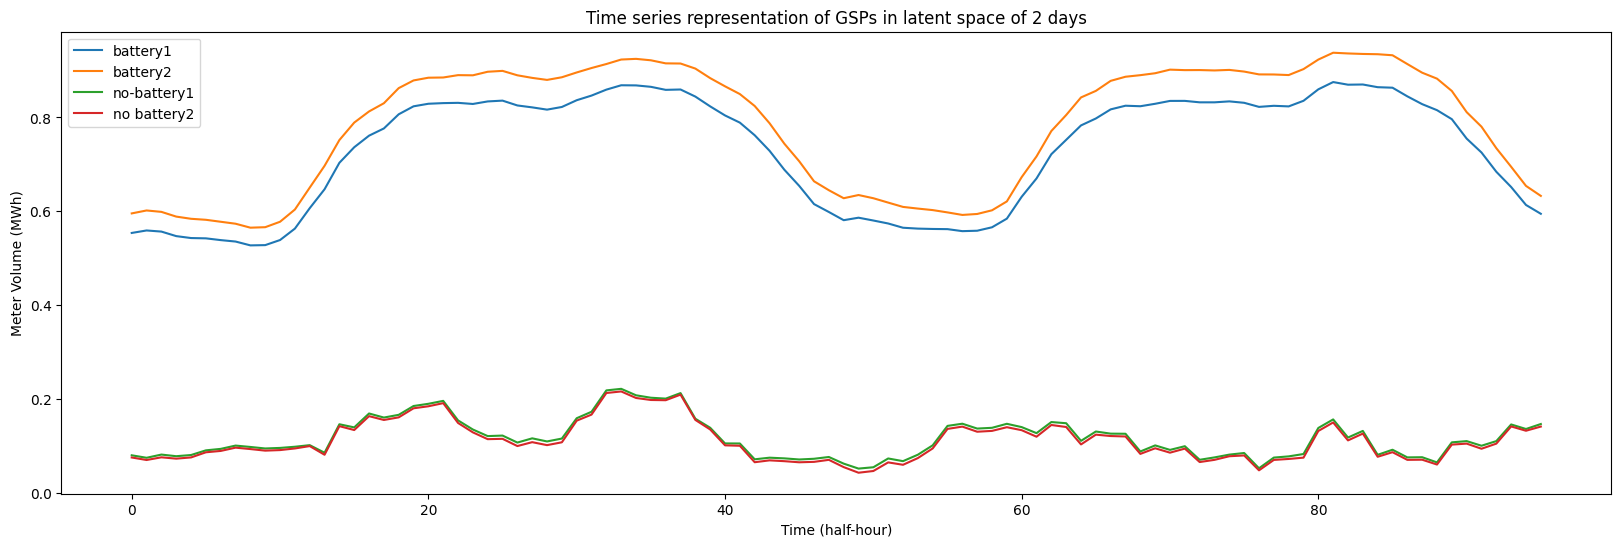

In [45]:
#print('No of days: ', no_of_days)
'''
time_stamps1 = []
for i in range(no_of_days):
    time_stamps1 = time_stamps1 + time_stamps
'''

fig, ax = plt.subplots(figsize=(20,6))
#ax.plot(time_stamps1, f1)
ax.plot(times, f1, label='battery'+'1')
ax.plot(times, f2, label='battery'+'2')
ax.plot(times, f3, label='no-battery'+'1')
ax.plot(times, f4, label='no battery'+'2')
#plt.xticks(ticks)
plt.legend()
plt.xlabel('Time (half-hour)')
plt.ylabel('Meter Volume (MWh)')
plt.title(f'Time series representation of GSPs in latent space of 2 days')
plt.show()

In [46]:
def marginal_points(X_battery_pts, cord_range):
    # Taking x & y coordinate of the battery points
    x_cord = X_battery_pts[:,0]
    y_cord = X_battery_pts[:,1]

    x_cond = np.logical_and(x_cord > cord_range['left'][0], x_cord < cord_range['left'][1])
    battery_left = X_battery_pts[x_cond]
    
    x_cond = np.logical_and(x_cord > cord_range['right'][0], x_cord < cord_range['right'][1])
    battery_right = X_battery_pts[x_cond]
    
    y_cond = np.logical_and(y_cord > cord_range['top'][0], y_cord < cord_range['top'][1])
    battery_top = X_battery_pts[y_cond]
    
    y_cond = np.logical_and(y_cord > cord_range['bottom'][0], y_cord < cord_range['bottom'][1])
    battery_bottom = X_battery_pts[y_cond]
    return battery_left, battery_right, battery_top, battery_bottom


def random_points(total_points):
    
    pt_indices = np.random.randint(0, len(total_points), size = 2)
    return total_points[pt_indices]


def plot_latent(latent_points, ax, direction):
    
    latent1 = torch.tensor([latent_points[0]])
    latent2 = torch.tensor([latent_points[1]])
    
    time_span = 96
    
    f1=get_mean(latent1)[:time_span]
    f2=get_mean(latent2)[:time_span]
    
    l=f1.shape[0]
    times=np.arange(int(l)) # half hourly interval

    #ax.plot(time_stamps1, f1)
    ax.plot(times, f1, label=direction+'1')
    ax.plot(times, f2, label=direction+'2')
    

In [47]:
# Battery marginal points
left_marginal, right_marginal, top_marginal, bottom_marginal = marginal_points(X_battery_pts, battery_coord_range)
print(len(bottom_marginal))

battery_left = random_points(left_marginal)
battery_right = random_points(right_marginal)
battery_top = random_points(top_marginal)
battery_bottom = random_points(bottom_marginal)

3


In [48]:
# No battery marginal points
left_marginal, right_marginal, top_marginal, bottom_marginal = marginal_points(X_no_battery_pts, no_battery_coord_range)
print(len(left_marginal))

no_battery_left = random_points(left_marginal)
no_battery_right = random_points(right_marginal)
no_battery_top = random_points(top_marginal)
no_battery_bottom = random_points(bottom_marginal)

7


battery points count:  289
no battery points count:  73


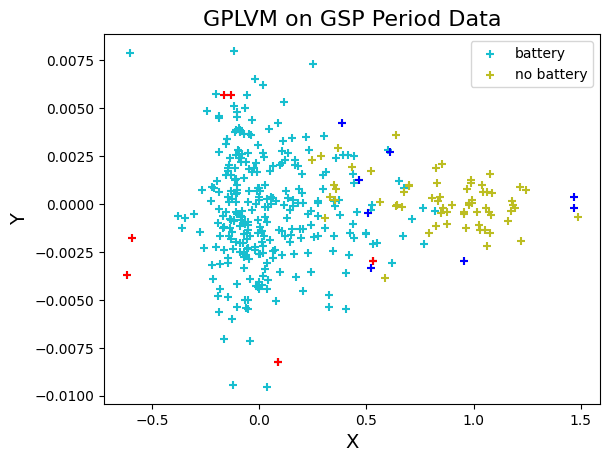

In [49]:
#plt.figure(figsize=(8, 6))
for i, label in enumerate(labels):

    X_i = X_out[df.index == label]
    print(battery_types[i], 'points count: ', len(X_i))
    plt.scatter(X_i[:, 0], X_i[:, 1], c=[colors[i]], marker='+', label=battery_types[i])

# Highlighting marginal points in the plot for battery
plt.scatter(battery_left[:, 0], battery_left[:, 1], c=['red'], marker='+')
plt.scatter(battery_right[:, 0], battery_right[:, 1], c=['red'], marker='+')
plt.scatter(battery_top[:, 0], battery_top[:, 1], c=['red'], marker='+')
plt.scatter(battery_bottom[:, 0], battery_bottom[:, 1], c=['red'], marker='+')

# Highlighting marginal points in the plot for no battery
plt.scatter(no_battery_left[:, 0], no_battery_left[:, 1], c=['blue'], marker='+')
plt.scatter(no_battery_right[:, 0], no_battery_right[:, 1], c=['blue'], marker='+')
plt.scatter(no_battery_top[:, 0], no_battery_top[:, 1], c=['blue'], marker='+')
plt.scatter(no_battery_bottom[:, 0], no_battery_bottom[:, 1], c=['blue'], marker='+')

plt.legend()
plt.xlabel("X", fontsize=14)
plt.ylabel("Y", fontsize=14)
plt.title("GPLVM on GSP Period Data", fontsize=16)
plt.show()

latent variable tensor([[-0.5938, -0.0018]]) variance= 0.25616172
latent variable tensor([[-0.6189, -0.0037]]) variance= 0.28504273
latent variable tensor([[ 0.5301, -0.0030]]) variance= 0.079816215
latent variable tensor([[ 0.5301, -0.0030]]) variance= 0.07980306


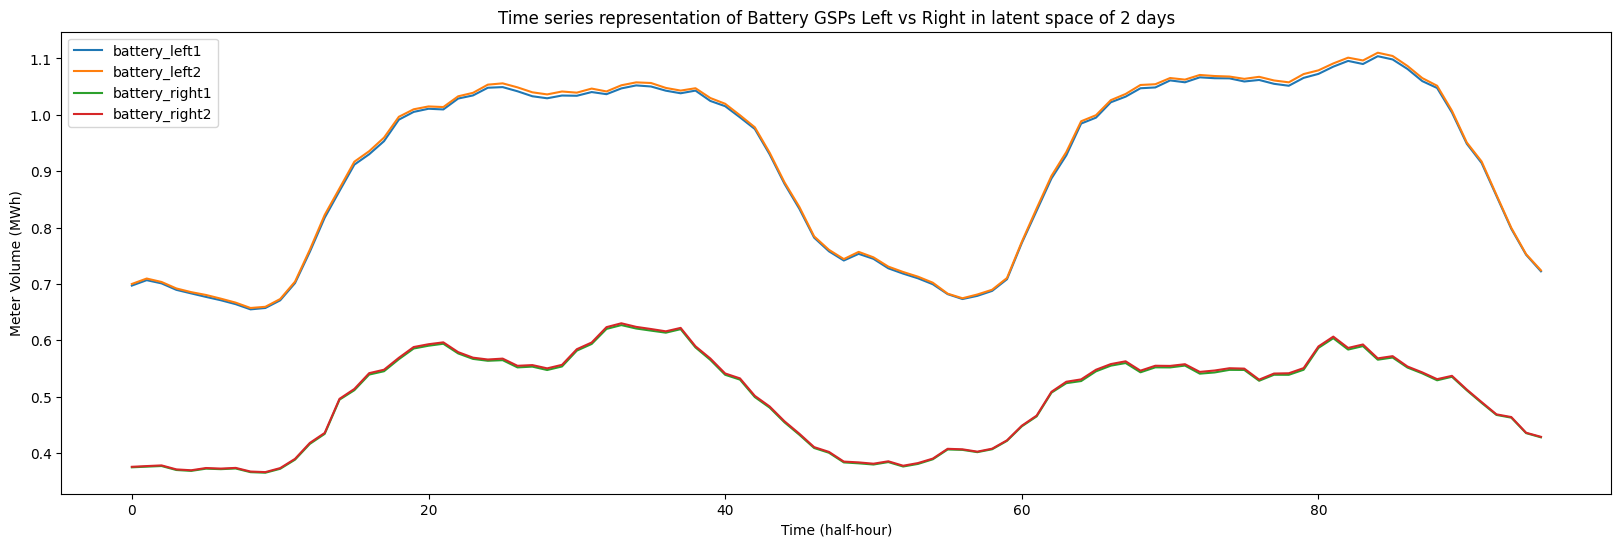

latent variable tensor([[-0.1633,  0.0057]]) variance= 0.007702713
latent variable tensor([[-0.1338,  0.0057]]) variance= 0.004455241
latent variable tensor([[ 0.0889, -0.0082]]) variance= 0.013204748
latent variable tensor([[ 0.0889, -0.0082]]) variance= 0.01320427


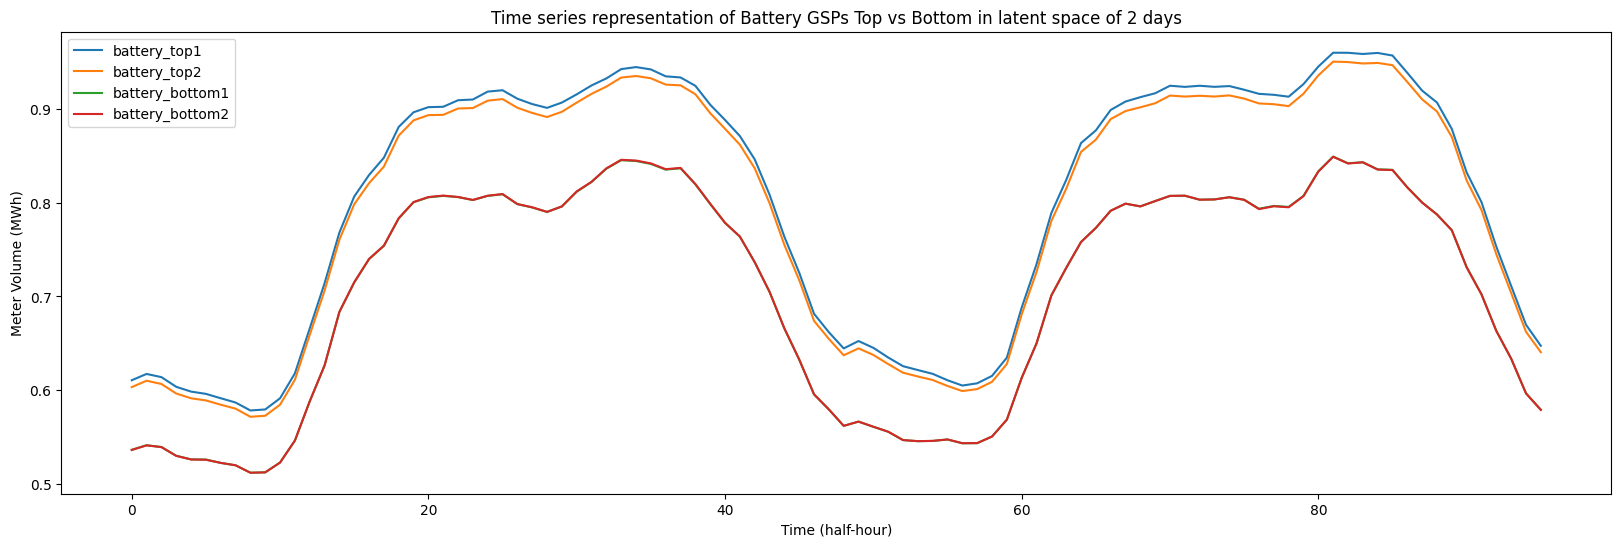

In [50]:
# For battery
# Plotting left vs right

fig, ax = plt.subplots(figsize=(20,6))
plot_latent(battery_left, ax, 'battery_left')
plot_latent(battery_right, ax, 'battery_right')
plt.legend()
plt.xlabel('Time (half-hour)')
plt.ylabel('Meter Volume (MWh)')
plt.title(f'Time series representation of Battery GSPs Left vs Right in latent space of 2 days')
plt.show()

# Plotting top vs bottom

fig, ax = plt.subplots(figsize=(20,6))
plot_latent(battery_top, ax, 'battery_top')
plot_latent(battery_bottom, ax, 'battery_bottom')
plt.legend()
plt.xlabel('Time (half-hour)')
plt.ylabel('Meter Volume (MWh)')
plt.title(f'Time series representation of Battery GSPs Top vs Bottom in latent space of 2 days')
plt.show()

latent variable tensor([[0.4668, 0.0013]]) variance= 0.07333716
latent variable tensor([[ 5.0538e-01, -4.4028e-04]]) variance= 0.0775373
latent variable tensor([[ 1.4689e+00, -2.0469e-04]]) variance= 0.014266651
latent variable tensor([[1.4691e+00, 3.4306e-04]]) variance= 0.014308547


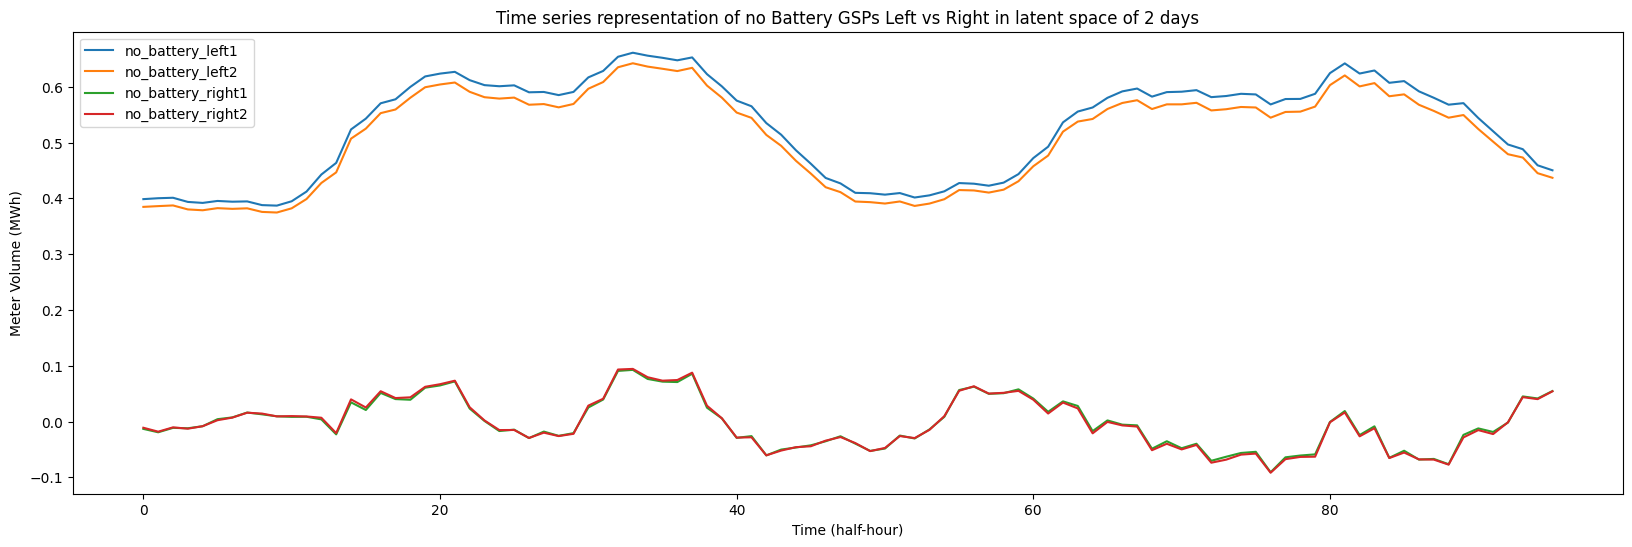

latent variable tensor([[0.3866, 0.0042]]) variance= 0.062324863
latent variable tensor([[0.6093, 0.0027]]) variance= 0.084587686
latent variable tensor([[ 0.9571, -0.0030]]) variance= 0.060297783
latent variable tensor([[ 0.5207, -0.0033]]) variance= 0.0789988


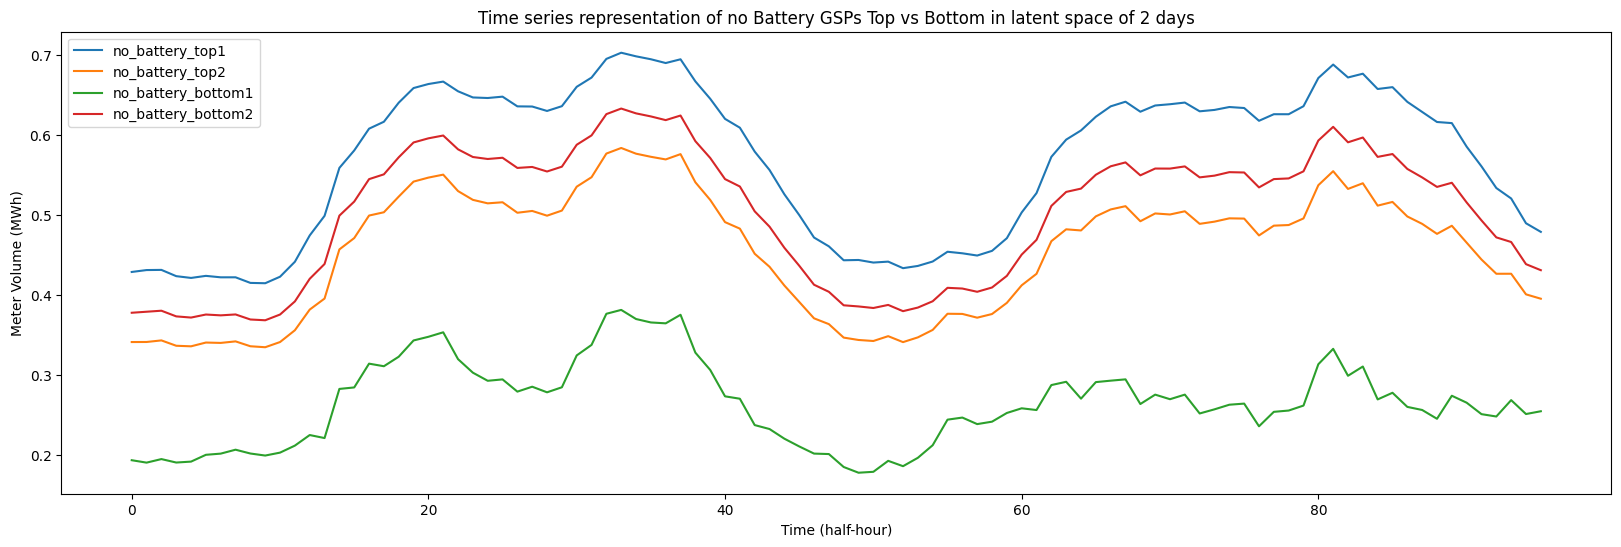

In [51]:
# For no battery
# Plotting left vs right

fig, ax = plt.subplots(figsize=(20,6))
plot_latent(no_battery_left, ax, 'no_battery_left')
plot_latent(no_battery_right, ax, 'no_battery_right')
plt.legend()
plt.xlabel('Time (half-hour)')
plt.ylabel('Meter Volume (MWh)')
plt.title(f'Time series representation of no Battery GSPs Left vs Right in latent space of 2 days')
plt.show()

# Plotting top vs bottom

fig, ax = plt.subplots(figsize=(20,6))
plot_latent(no_battery_top, ax, 'no_battery_top')
plot_latent(no_battery_bottom, ax, 'no_battery_bottom')
plt.legend()
plt.xlabel('Time (half-hour)')
plt.ylabel('Meter Volume (MWh)')
plt.title(f'Time series representation of no Battery GSPs Top vs Bottom in latent space of 2 days')
plt.show()

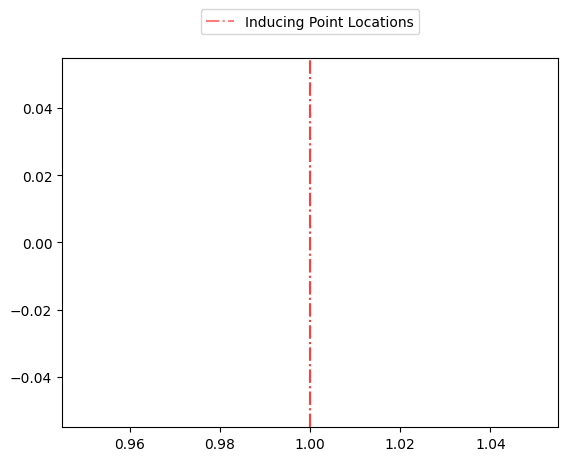

In [52]:
from pyro.contrib.gp import util

def plot_inducing_points(Xu, ax=None):
    for xu in Xu:
        g = ax.axvline(xu.any(), color="red", linestyle="-.", alpha=0.5)
    ax.legend(
        handles=[g],
        labels=["Inducing Point Locations"],
        bbox_to_anchor=(0.5, 1.15),
        loc="upper center",
    )


plt.plot(model=gplvm, plot_observed_data=True, plot_predictions=True)
plot_inducing_points(gplvm.Xu.data.numpy(), plt.gca())

In [53]:
#specific_gsp_data_copy
specific_gsp_data_copy_filtr = specific_gsp_data_copy.loc['20221111':'20221112']

In [54]:
specific_gsp_data_copy_filtr



,GSP Id,Settlement Period,Meter Volume
Settlement Date,,,
20221111,WOHI_P,1,7.077
20221111,WOHI_P,2,6.704
20221111,WOHI_P,3,6.559
20221111,WOHI_P,4,6.424
20221111,WOHI_P,5,6.183
...,...,...,...
20221112,WOHI_P,44,8.199
20221112,WOHI_P,45,7.783
20221112,WOHI_P,46,7.448
